# 评分卡制作

该数据是信贷数据,来自kaggle2011年的竞赛数据:[Give Me Some Credit](https://www.kaggle.com/c/GiveMeSomeCredit/overview),评判指标是AUC

- SeriousDlqin2yrs:出现90天或更长时间的逾期行为(即定义好坏客户)
- RevolvingUtilizationOfUnsecuredLines:贷款以及信用卡可用额度与总额度比例
- age:借款人借款年龄
- NumberOfTime30-59DaysPastDueNotWorse:过去两年内出现35-59天逾期但是没有发展的更坏的次数
- DebtRatio:每月偿还债务,赡养费,生活费用除以月总收入
- MonthlyIncome:月收入
- NumberOfOpenCreditLinesAndLoans:开放式贷款和信贷数量
- NumberOfTimes90DaysLate:借款者有90天或更高逾期的次数
- NumberRealEstateLoansOrLines:抵押贷款和房地产贷款数量,包括房屋净值信贷额度
- NumberOfTime60-89DaysPastDueNotWorse:过去两年内出现60-89天逾期但是没有发展的更坏的次数
- NumberOfDependents:家庭中不包括自身的家属人数(配偶,子女等)

加载所需包

In [1]:
%matplotlib inline
#图示魔法函数
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from collections import Counter                         #计数器，返回的结果是字典
#collections:高性能容量数据类型库
from sklearn.model_selection import train_test_split
import scipy.stats as stats                             
#scipy.stats:统计分析包,包含各种分布
import seaborn as sns
import statsmodels.api as sm                            #标准回归模型库
from statsmodels.stats.outliers_influence import variance_inflation_factor
# statsmodels:用于拟合多种统计模型，执行统计测试以及数据探索和可视化
# variance_inflation_factor:方差膨胀系数(VIF)计算方法

In [2]:
import warnings
warnings.filterwarnings(action='once')  
# 相同警告只出现一次

# warnings.filterwarnings(action='ignore')  #忽略所有警告信息

In [3]:
#先定位文件存储位置
os.chdir(r'E:\Data analysis\CDA\learning\0、python自己练习\6、机器学习')

## 读数据,数据描述

In [4]:
train_data=pd.read_csv('data/CreditScore_data/cs-training.csv',index_col=0)
# index_col指明y的索引是第几列

In [5]:
train_data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [269]:
print(train_data.shape)
train_data.describe(include='all',percentiles=[0.5]).T.round(2)

(150000, 11)


,count,mean,std,min,50%,max
SeriousDlqin2yrs,150000.0,0.07,0.25,0.0,0.00,1.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.05,249.76,0.0,0.15,50708.0
age,150000.0,52.30,14.77,0.0,52.00,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.42,4.19,0.0,0.00,98.0
DebtRatio,150000.0,353.01,2037.82,0.0,0.37,329664.0
MonthlyIncome,120269.0,6670.22,14384.67,0.0,5400.00,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.45,5.15,0.0,8.00,58.0
NumberOfTimes90DaysLate,150000.0,0.27,4.17,0.0,0.00,98.0
NumberRealEstateLoansOrLines,150000.0,1.02,1.13,0.0,1.00,54.0
NumberOfTime60-89DaysPastDueNotWorse,150000.0,0.24,4.16,0.0,0.00,98.0


修改列名:由于一些算法中,列名中的某些符号会带来问题甚至报错,例如这里的"-",会在回归公式中被认为是减号,所以换成"_"

In [7]:
train_data.columns=train_data.columns.map(lambda x:x.replace('-','_'))

查看各列缺失值占比

In [272]:
train_data.isnull().mean()

SeriousDlqin2yrs                        0.000000
RevolvingUtilizationOfUnsecuredLines    0.000000
age                                     0.000000
NumberOfTime30_59DaysPastDueNotWorse    0.000000
DebtRatio                               0.000000
MonthlyIncome                           0.198207
NumberOfOpenCreditLinesAndLoans         0.000000
NumberOfTimes90DaysLate                 0.000000
NumberRealEstateLoansOrLines            0.000000
NumberOfTime60_89DaysPastDueNotWorse    0.000000
NumberOfDependents                      0.026160
dtype: float64

### 去重
- 对于一般模型影响不大,容易导致回归系数标准误降低,使得对应p值减小

In [8]:
train_data.drop_duplicates(inplace=True)
train_data.shape

(149391, 11)

- 可见数据中存在重复行

## 缺失值处理

缺失值处理方法的选择,主要依据是业务逻辑和缺失值占比,在对预测结果的影响尽可能小的情况下,对缺失值进行处理以满足算法需求,所以要理解每个缺失值处理方法带来的影响,下面的缺失值处理方法没有特殊说明均是对特征(列)的处理:

1. 占比较多:如80%以上:删除缺失值所在的列
    - 如果某些行缺失值占比较多,或者缺失值所在字段是苛刻的必须有值的,删除行
2. 占比一般:如30%-80%:将缺失值作为单独的一个分类
    - 如果特征是连续的,则其他已有值分箱
    - 如果特征是分类的,考虑其他分类是否需要重分箱
3. 占比少:10%-30%:多重插补:认为若干特征之间有相关性,则可以相互预测缺失值
    - 需满足的假设:MAR:Missing At Random:数据缺失的概率仅和已观测的数据相关,即缺失的概率与未知的数据无关,即与变量的具体数值无关
    - 迭代(循环)次数可能的话超过40,选择所有的变量甚至额外的辅助变量
    - 详细的计算过程参考:[Multiple Imputation by Chained Equations: What is it and how does it work?](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074241/)
4. 占比较少:10%以下:单一值替换,如中位数,众数
5. 在决策树中可以将缺失值处理融合到算法里:按比重分配

这里的占比并不是固定的,例如缺失值占比只有5%,仍可以用第二种方法,主要依据业务逻辑和算法需求

### 查看缺失值分布情况

In [384]:
import missingno as msno
# 处理缺失值的包,需要安装

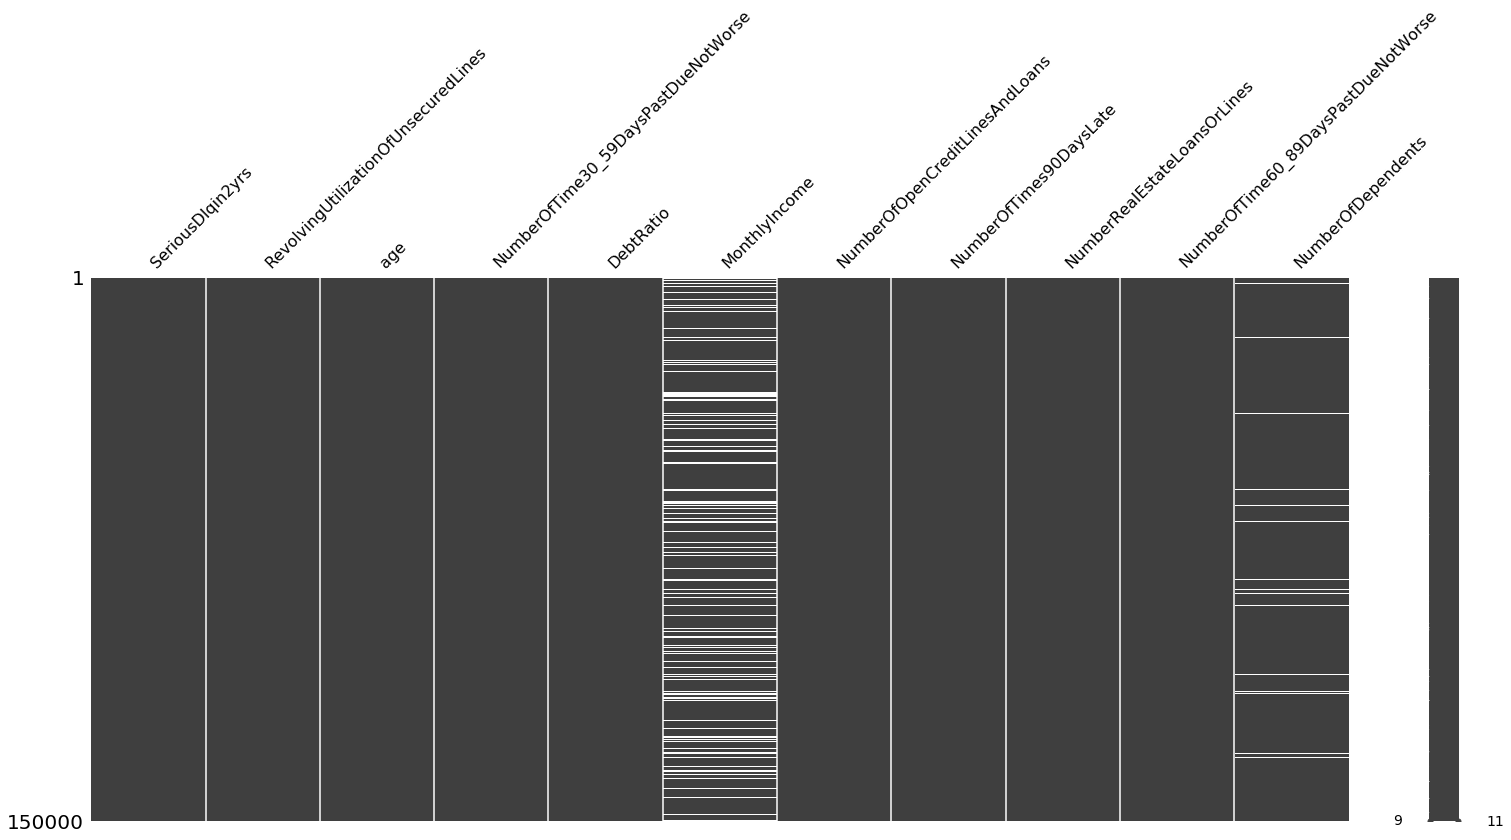

In [277]:
msno.matrix(train_data)
plt.show()
#展示列是否存在缺失值图形

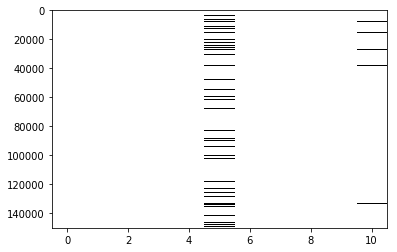

In [282]:
plt.imshow(~train_data.isnull(),aspect='auto')
plt.gray()  #无背景色

本数据的缺失值处理逻辑:

- 对于信用评分卡来说,由于所有变量都需要分箱,故这里缺失值作为单独的箱子即可
- 对于最后一列NumberOfDependents,缺失值占比只有2.56%,作为单独的箱子信息不够,故做单一值填补,这列表示家庭人口数,有右偏的倾向,且属于计数的数据,故使用中位数填补

### 单一值替换
- 将最后一列NumberOfDependents的缺失值替换成中位数

In [9]:
#方法一：
NOD_median=train_data['NumberOfDependents'].median()
train_data['NumberOfDependents'].fillna(NOD_median,inplace=True)
# fillna填补缺失值的函数,这里用中位数填补

In [294]:
#方法二：
from sklearn.impute import SimpleImputer
si=SimpleImputer(missing_values=np.nan,strategy='median')
si=si.fit(train_data['NumberOfDependents'])
train_data['NumberOfDependents']=si.transform(train_data['NumberOfDependents'])

## 异常值处理

异常值常见的处理方法:

1. 删除所在的行
2. 替换成缺失值,与缺失值一起处理
3. 盖帽法处理

结合业务逻辑和算法需求判断是否需要处理异常值以及如何处理,一般情况下盖帽法即可,即将极端异常的值改成不那么异常的极值,当然一些算法例如决策树中连续变量的异常值也可以不做处理

### 定义盖帽法函数

In [10]:
def block(x,lower=True,upper=True):
# x是输入的Series对象,lower表示是否替换1%分位数,upper表示是否替换99%分位数
    ql=x.quantile(0.01)
    qu=x.quantile(0.99)
    if lower:
        out=x.mask(x<ql,ql)
    if upper:
        out=x.mask(x>qu,qu)
    return out

- 互换y中的0,1

In [11]:
train_data["SeriousDlqin2yrs"]=-(train_data.SeriousDlqin2yrs-1)

## 汇总清洗过程,生成函数

In [12]:
def datacleaning(testdata,include_y=False):
    testdata.columns=testdata.columns.map(lambda x:x.replace('-','_'))
    testdata['NumberOfDependents'].fillna(NOD_median,inplace=True)      #新数据的缺失值需要用训练集的填充方式处理
    if include_y:
        testdata["SeriousDlqin2yrs"]=-(testdata.SeriousDlqin2yrs-1)  #sklearn的pipeline或独热编码方式处理
    return testdata

## 对每个x生成分箱对象

对每个x生成一个对象;记录IV值;生成WOE图

- 运行自定义函数所在的文件

In [13]:
%run custom_function/smob.py
# 导入自定义函数文件smob.py，其中有生成树算法、自动WOE分箱方法

- 定义y的名字
- 初始化IV值对象

In [14]:
y='SeriousDlqin2yrs'
iv_all=pd.Series()

### RevolvingUtilizationOfUnsecuredLines

D:\tool\anaconda\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


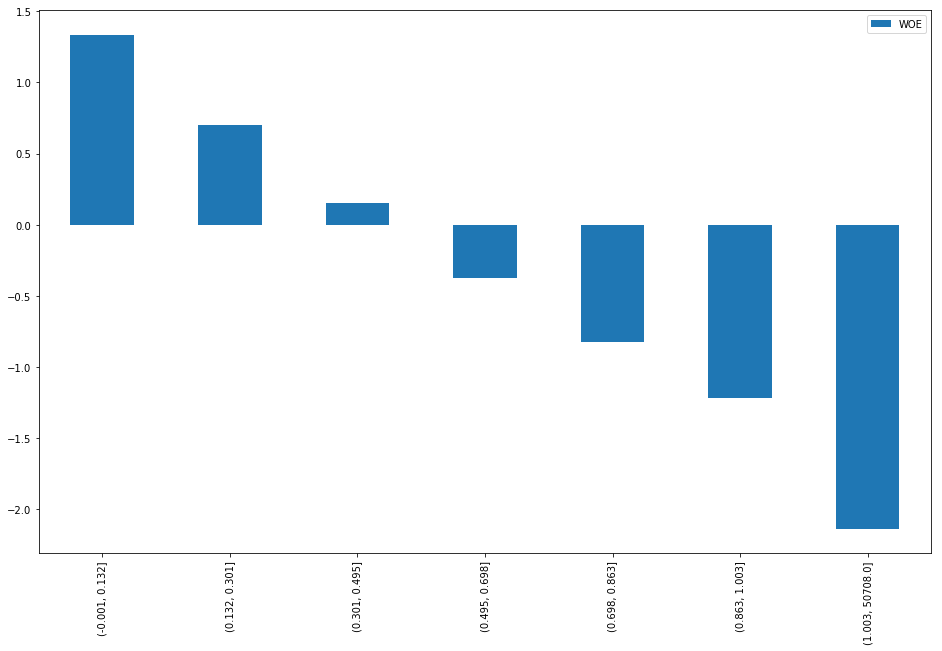

In [15]:
RUO=smbin(train_data,y,'RevolvingUtilizationOfUnsecuredLines')

- 查看IVtable

In [393]:
RUO.IVtable

,Bins,CntRec,CntGood,CntBad,PctRec,PctGood,PctBad,WOE,IV
0,"(-0.001, 0.132]",70734,69424,1310,0.473482,0.498084,0.130882,1.3365,0.4908
1,"(0.132, 0.301]",21938,21185,753,0.146850,0.151992,0.075232,0.7032,0.0540
2,"(0.301, 0.495]",15380,14486,894,0.102951,0.103930,0.089320,0.1515,0.0022
3,"(0.495, 0.698]",11599,10499,1100,0.077642,0.075325,0.109901,-0.3778,0.0131
4,"(0.698, 0.863]",7985,6860,1125,0.053450,0.049217,0.112399,-0.8258,0.0522
5,"(0.863, 1.003]",18592,14962,3630,0.124452,0.107345,0.362674,-1.2175,0.3109
6,"(1.003, 50708.0]",3163,1966,1197,0.021173,0.014105,0.119592,-2.1376,0.2255
7,Total,149391,139382,10009,1.000000,1.000000,1.000000,NaN,1.1487


- 查看树结构

In [394]:
print(RUO.Tree_structure)

The cart tree structure has 13 nodes, tree structure: 
node = 0 test node: go to node 1 if RevolvingUtilizationOfUnsecuredLines <= 0.7 else to node 2.
	node = 1 test node: go to node 5 if RevolvingUtilizationOfUnsecuredLines <= 0.3 else to node 6.
	node = 2 test node: go to node 3 if RevolvingUtilizationOfUnsecuredLines <= 1.0 else to node 4.
		node = 3 test node: go to node 7 if RevolvingUtilizationOfUnsecuredLines <= 0.86 else to node 8.
		node = 4 leaf node.
		node = 5 test node: go to node 11 if RevolvingUtilizationOfUnsecuredLines <= 0.13 else to node 12.
		node = 6 test node: go to node 9 if RevolvingUtilizationOfUnsecuredLines <= 0.49 else to node 10.
			node = 7 leaf node.
			node = 8 leaf node.
			node = 9 leaf node.
			node = 10 leaf node.
			node = 11 leaf node.
			node = 12 leaf node.



- 保存IV值

In [395]:
RUO.IV

1.1487

In [16]:
iv_all=iv_all.append(pd.Series({'RevolvingUtilizationOfUnsecuredLines':RUO.IV}))

### age

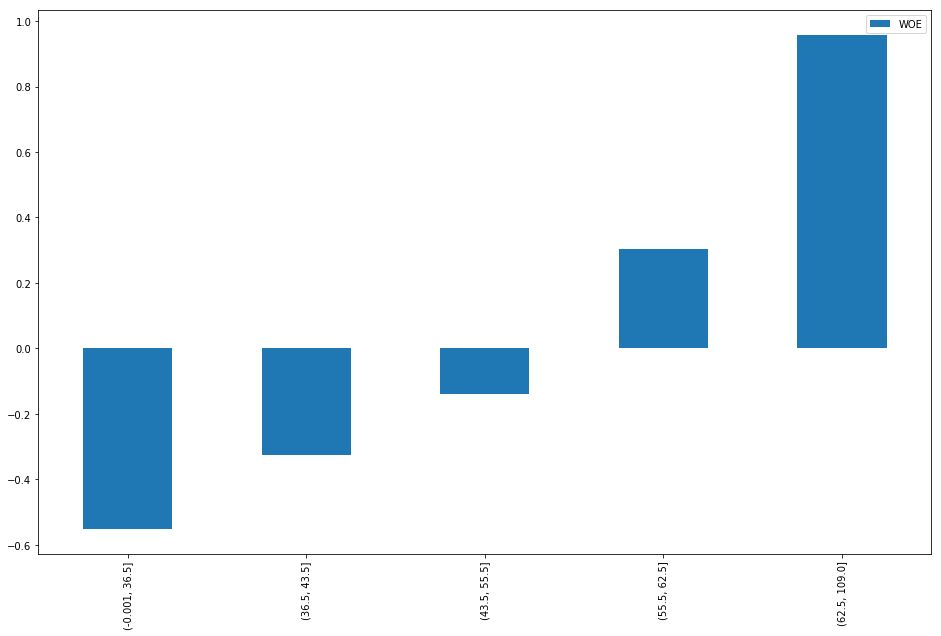

In [17]:
age=smbin(train_data,y,'age')

- 查看IVtable

In [399]:
age.IVtable

,Bins,CntRec,CntGood,CntBad,PctRec,PctGood,PctBad,WOE,IV
0,"(-0.001, 36.5]",23628,21011,2617,0.158162,0.150744,0.261465,-0.5507,0.0610
1,"(36.5, 43.5]",20609,18746,1863,0.137953,0.134494,0.186132,-0.3249,0.0168
2,"(43.5, 55.5]",43428,40119,3309,0.290700,0.287835,0.330602,-0.1385,0.0059
3,"(55.5, 62.5]",23972,22764,1208,0.160465,0.163321,0.120691,0.3025,0.0129
4,"(62.5, 109.0]",37754,36742,1012,0.252719,0.263606,0.101109,0.9583,0.1557
5,Total,149391,139382,10009,1.000000,1.000000,1.000000,NaN,0.2523


- 保存IV值

In [401]:
age.IV

0.25229999999999997

In [18]:
iv_all=iv_all.append(pd.Series({'age':age.IV}))

### NumberOfTime30_59DaysPastDueNotWorse

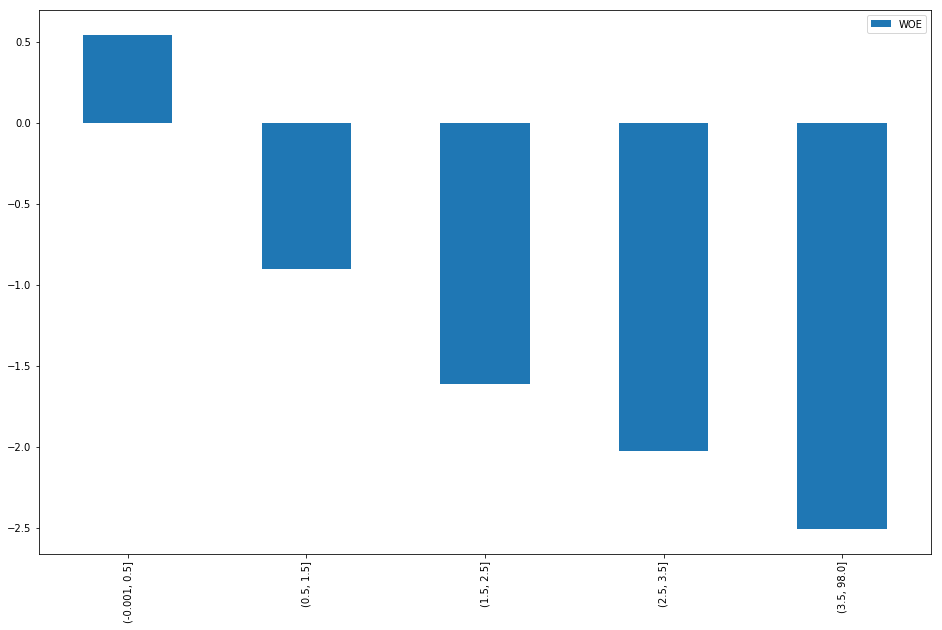

In [19]:
NO3059=smbin(train_data,y,'NumberOfTime30_59DaysPastDueNotWorse')

In [406]:
NO3059.IVtable

,Bins,CntRec,CntGood,CntBad,PctRec,PctGood,PctBad,WOE,IV
0,"(-0.001, 0.5]",125453,120418,5035,0.839763,0.863942,0.503047,0.5408,0.1952
1,"(0.5, 1.5]",16033,13624,2409,0.107322,0.097746,0.240683,-0.9011,0.1288
2,"(1.5, 2.5]",4598,3379,1219,0.030778,0.024243,0.121790,-1.6142,0.1575
3,"(2.5, 3.5]",1754,1136,618,0.011741,0.008150,0.061744,-2.0250,0.1085
4,"(3.5, 98.0]",1553,825,728,0.010396,0.005919,0.072735,-2.5087,0.1676
5,Total,149391,139382,10009,1.000000,1.000000,1.000000,NaN,0.7576


In [20]:
iv_all=iv_all.append(pd.Series({'NumberOfTime30_59DaysPastDueNotWorse':NO3059.IV}))

### DebtRatio

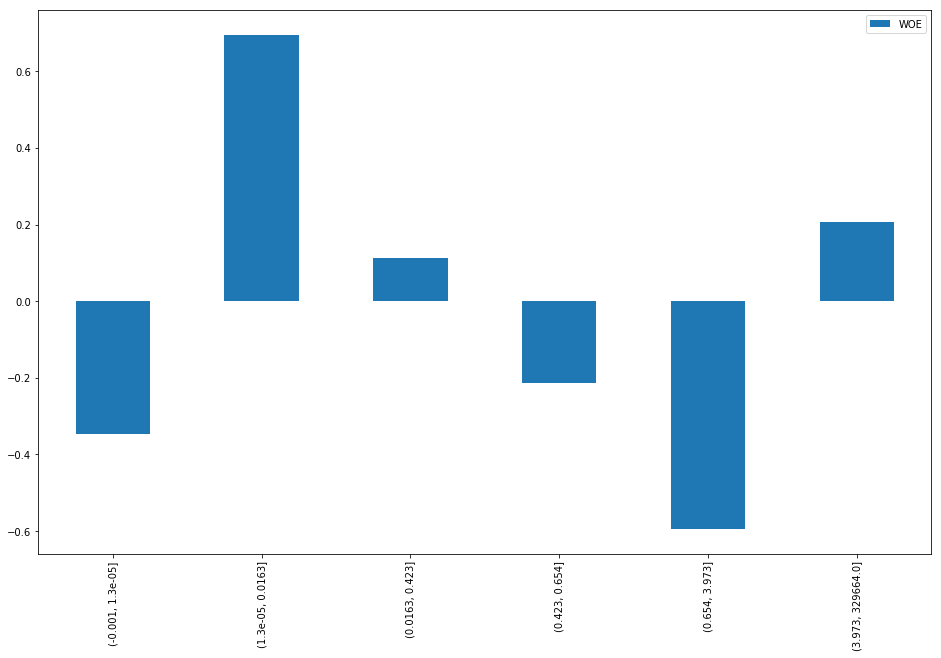

In [21]:
DebtRatio=smbin(train_data,y,'DebtRatio',10)

In [409]:
DebtRatio.IVtable

,Bins,CntRec,CntGood,CntBad,PctRec,PctGood,PctBad,WOE,IV
0,"(-0.001, 1.3e-05]",3515,3191,324,0.023529,0.022894,0.032371,-0.3464,0.0033
1,"(1.3e-05, 0.0163]",8296,8009,287,0.055532,0.057461,0.028674,0.6951,0.0200
2,"(0.0163, 0.423]",71689,67363,4326,0.479875,0.483298,0.432211,0.1117,0.0057
3,"(0.423, 0.654]",21179,19451,1728,0.141769,0.139552,0.172645,-0.2128,0.0070
4,"(0.654, 3.973]",14648,12961,1687,0.098051,0.092989,0.168548,-0.5947,0.0449
5,"(3.973, 329664.0]",30064,28407,1657,0.201244,0.203807,0.165551,0.2079,0.0080
6,Total,149391,139382,10009,1.000000,1.000000,1.000000,NaN,0.0889


In [22]:
iv_all=iv_all.append(pd.Series({'DebtRatio':DebtRatio.IV}))

### MonthlyIncome

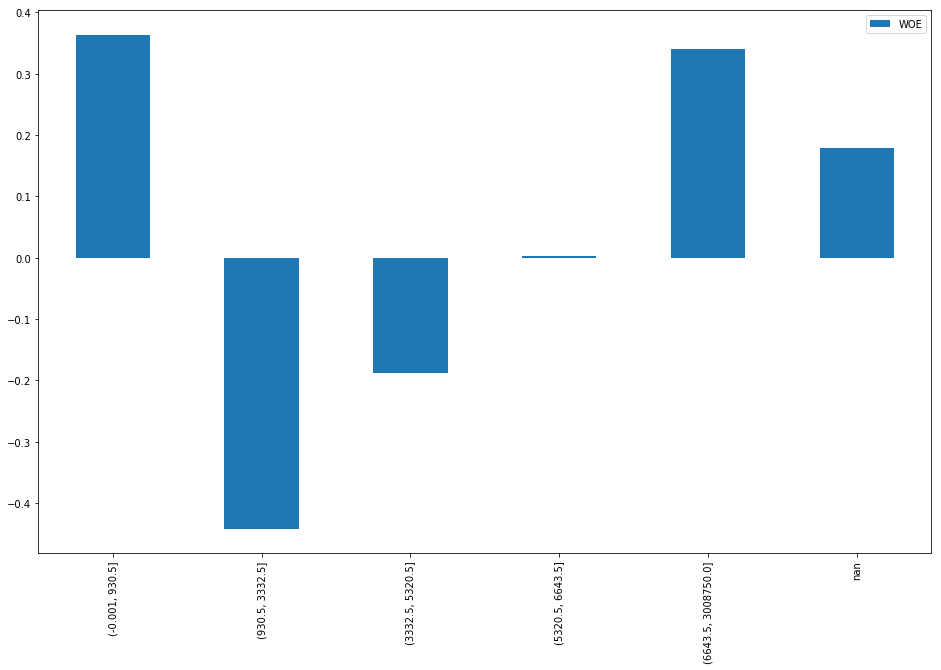

In [23]:
MonthlyIncome=smbin(train_data,y,'MonthlyIncome')

In [413]:
MonthlyIncome.IVtable

,Bins,CntRec,CntGood,CntBad,PctRec,PctGood,PctBad,WOE,IV
0,"(-0.001, 930.5]",4229,4028,201,0.028308,0.028899,0.020082,0.3640,0.0032
1,"(930.5, 3332.5]",24574,22105,2469,0.164495,0.158593,0.246678,-0.4417,0.0389
2,"(3332.5, 5320.5]",30421,27994,2427,0.203633,0.200844,0.242482,-0.1884,0.0078
3,"(5320.5, 6643.5]",16128,15050,1078,0.107958,0.107977,0.107703,0.0025,0.0000
4,"(6643.5, 3008750.0]",44818,42638,2180,0.300005,0.305908,0.217804,0.3397,0.0299
5,nan,29221,27567,1654,0.195601,0.197780,0.165251,0.1797,0.0058
6,Total,149391,139382,10009,1.000000,1.000000,1.000000,NaN,0.0856


In [24]:
iv_all=iv_all.append(pd.Series({'MonthlyIncome':MonthlyIncome.IV}))

### NumberOfOpenCreditLinesAndLoans

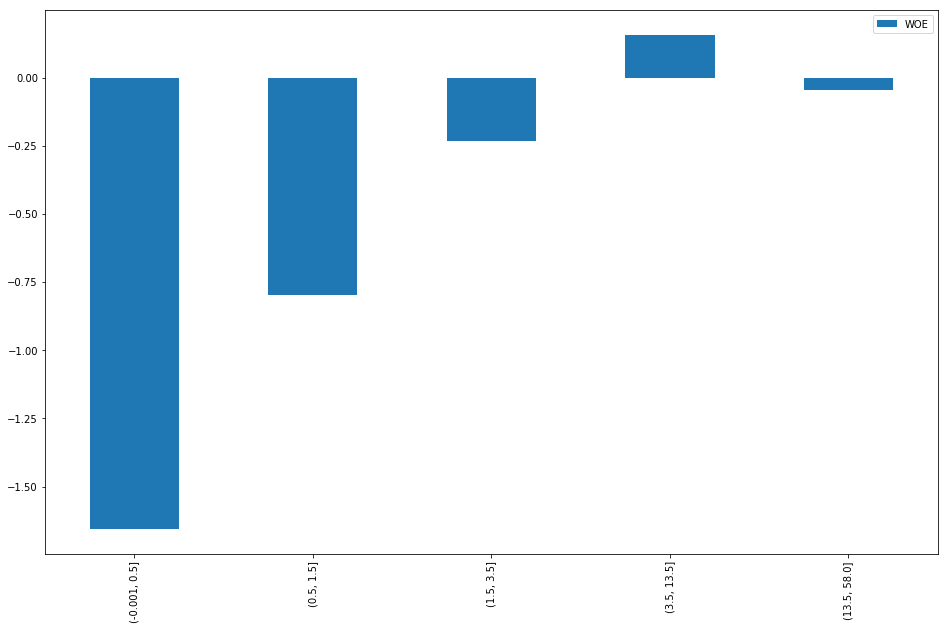

In [25]:
NOO=smbin(train_data,y,'NumberOfOpenCreditLinesAndLoans')  

In [416]:
NOO.IVtable

,Bins,CntRec,CntGood,CntBad,PctRec,PctGood,PctBad,WOE,IV
0,"(-0.001, 0.5]",1712,1244,468,0.011460,0.008925,0.046758,-1.6561,0.0627
1,"(0.5, 1.5]",4251,3667,584,0.028456,0.026309,0.058347,-0.7965,0.0255
2,"(1.5, 3.5]",15550,14259,1291,0.104089,0.102302,0.128984,-0.2318,0.0062
3,"(3.5, 13.5]",105861,99732,6129,0.708617,0.715530,0.612349,0.1557,0.0161
4,"(13.5, 58.0]",22017,20480,1537,0.147378,0.146934,0.153562,-0.0441,0.0003
5,Total,149391,139382,10009,1.000000,1.000000,1.000000,NaN,0.1108


In [26]:
iv_all=iv_all.append(pd.Series({'NumberOfOpenCreditLinesAndLoans':NOO.IV}))

### NumberOfTimes90DaysLate

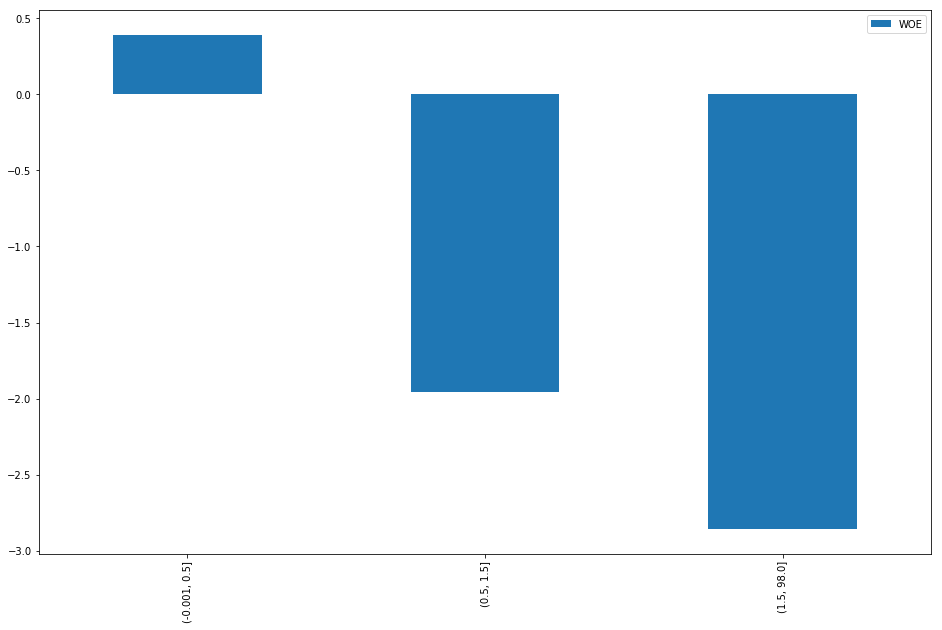

In [27]:
NO90=smbin(train_data,y,'NumberOfTimes90DaysLate')

In [419]:
NO90.IVtable

,Bins,CntRec,CntGood,CntBad,PctRec,PctGood,PctBad,WOE,IV
0,"(-0.001, 0.5]",141108,134559,6549,0.944555,0.965397,0.654311,0.3890,0.1210
1,"(0.5, 1.5]",5232,3468,1764,0.035022,0.024881,0.176241,-1.9577,0.2963
2,"(1.5, 98.0]",3051,1355,1696,0.020423,0.009721,0.169447,-2.8582,0.4565
3,Total,149391,139382,10009,1.000000,1.000000,1.000000,NaN,0.8738


In [28]:
iv_all=iv_all.append(pd.Series({'NumberOfTimes90DaysLate':NO90.IV}))

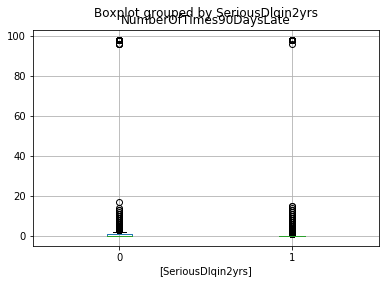

In [29]:
train_data.boxplot(column=['NumberOfTimes90DaysLate'],by=[y])

In [30]:
stats.ttest_ind(train_data.loc[train_data.SeriousDlqin2yrs==1,'NumberOfTimes90DaysLate'],
               train_data.loc[train_data.SeriousDlqin2yrs==0,'NumberOfTimes90DaysLate'])

Ttest_indResult(statistic=-47.704547090568376, pvalue=0.0)

In [31]:
t0=block(train_data['NumberOfTimes90DaysLate'])

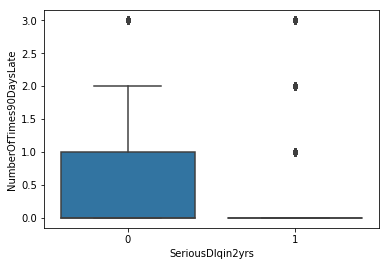

In [32]:
sns.boxplot(x=train_data[y],y=t0)

### NumberRealEstateLoansOrLines 

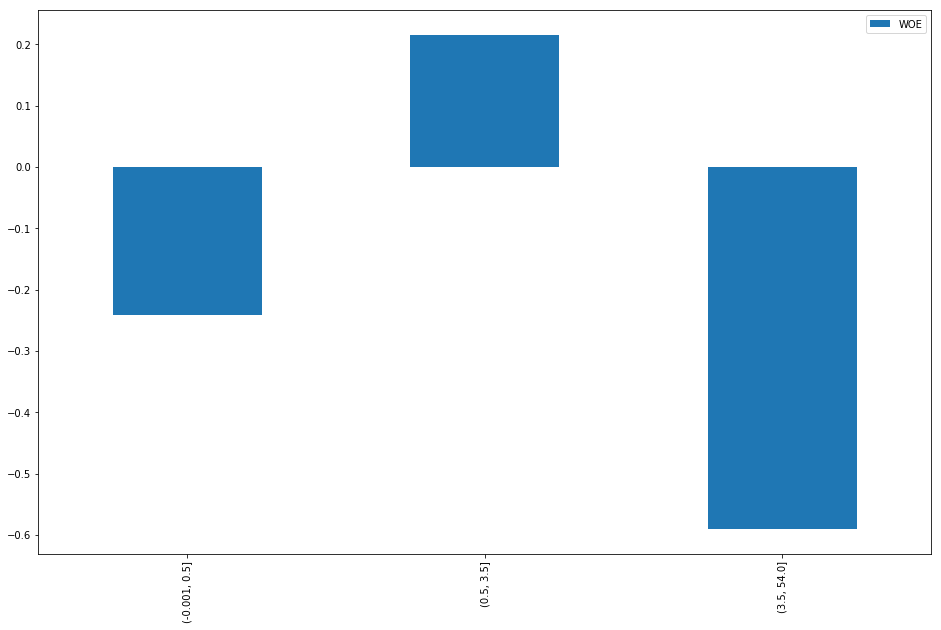

In [33]:
NRE=smbin(train_data,y,'NumberRealEstateLoansOrLines')

In [428]:
NRE.IVtable

,Bins,CntRec,CntGood,CntBad,PctRec,PctGood,PctBad,WOE,IV
0,"(-0.001, 0.5]",55579,50924,4655,0.372037,0.365356,0.465081,-0.2413,0.0241
1,"(0.5, 3.5]",90160,85225,4935,0.603517,0.611449,0.493056,0.2152,0.0255
2,"(3.5, 54.0]",3652,3233,419,0.024446,0.023195,0.041862,-0.5904,0.0110
3,Total,149391,139382,10009,1.000000,1.000000,1.000000,NaN,0.0606


In [34]:
iv_all=iv_all.append(pd.Series({'NumberRealEstateLoansOrLines':NRE.IV}))

### NumberOfTime60_89DaysPastDueNotWorse

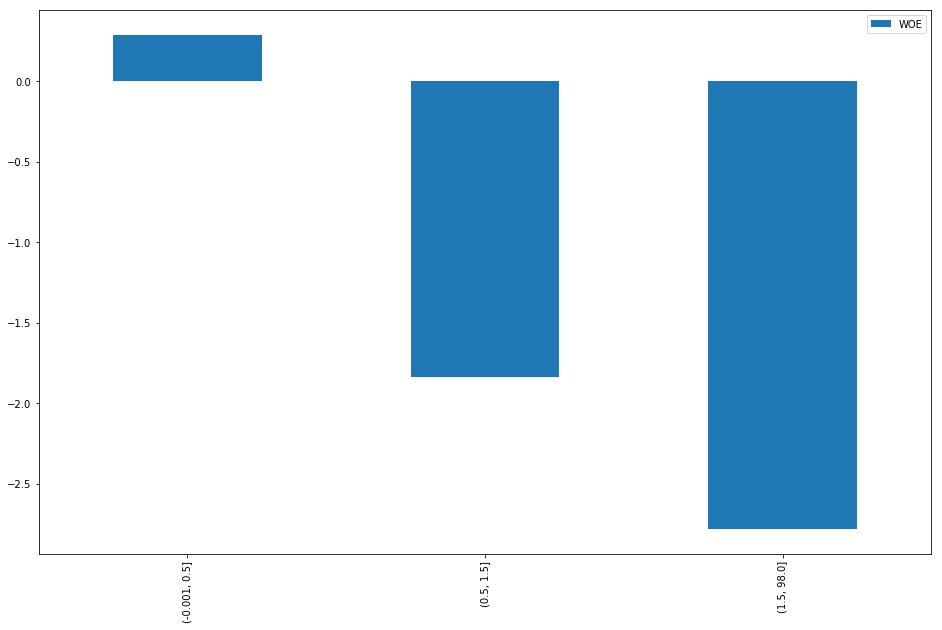

In [35]:
NO6089=smbin(train_data,y,'NumberOfTime60_89DaysPastDueNotWorse')

In [431]:
NO6089.IVtable

,Bins,CntRec,CntGood,CntBad,PctRec,PctGood,PctBad,WOE,IV
0,"(-0.001, 0.5]",141831,134581,7250,0.949395,0.965555,0.724348,0.2874,0.0693
1,"(0.5, 1.5]",5731,3954,1777,0.038362,0.028368,0.177540,-1.8339,0.2736
2,"(1.5, 98.0]",1829,847,982,0.012243,0.006077,0.098112,-2.7816,0.2560
3,Total,149391,139382,10009,1.000000,1.000000,1.000000,NaN,0.5989


In [36]:
iv_all=iv_all.append(pd.Series({'NumberOfTime60_89DaysPastDueNotWorse':NO6089.IV}))

### NumberOfDependents

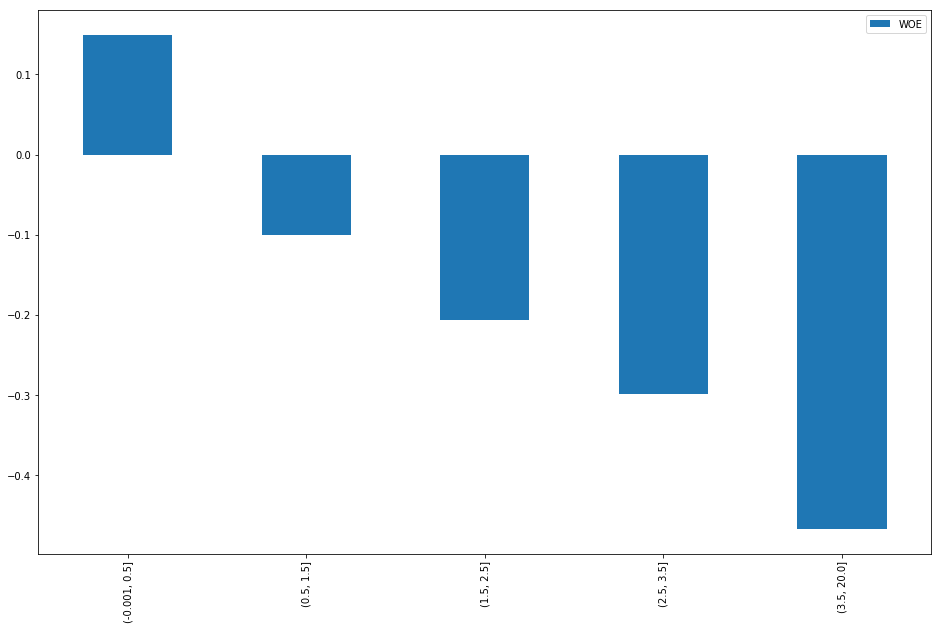

In [37]:
NOD=smbin(train_data,y,'NumberOfDependents')

In [434]:
NOD.IVtable

,Bins,CntRec,CntGood,CntBad,PctRec,PctGood,PctBad,WOE,IV
0,"(-0.001, 0.5]",90220,84963,5257,0.603919,0.609569,0.525227,0.1489,0.0126
1,"(0.5, 1.5]",26314,24379,1935,0.176142,0.174908,0.193326,-0.1001,0.0018
2,"(1.5, 2.5]",19521,17937,1584,0.130671,0.128690,0.158258,-0.2068,0.0061
3,"(2.5, 3.5]",9483,8646,837,0.063478,0.062031,0.083625,-0.2987,0.0065
4,"(3.5, 20.0]",3853,3457,396,0.025791,0.024802,0.039564,-0.4670,0.0069
5,Total,149391,139382,10009,1.000000,1.000000,1.000000,NaN,0.0339


In [38]:
iv_all=iv_all.append(pd.Series({'NumberOfDependents':NOD.IV}))

## 查看所有变量IV值
- IV值用于筛选变量,删除小于0.02的变量

In [438]:
iv_all.sort_values(ascending=False)

RevolvingUtilizationOfUnsecuredLines    1.1487
NumberOfTimes90DaysLate                 0.8738
NumberOfTime30_59DaysPastDueNotWorse    0.7576
NumberOfTime60_89DaysPastDueNotWorse    0.5989
age                                     0.2523
NumberOfOpenCreditLinesAndLoans         0.1108
DebtRatio                               0.0889
MonthlyIncome                           0.0856
NumberRealEstateLoansOrLines            0.0606
NumberOfDependents                      0.0339
dtype: float64

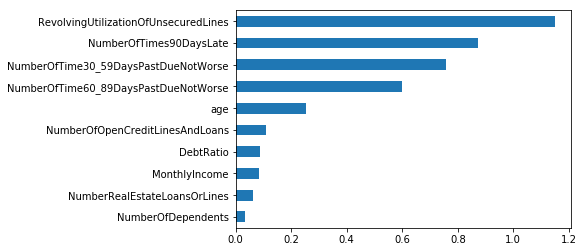

In [441]:
iv_all.sort_values().plot(kind='barh')

- 可见所有的IV值均大于0.02,故这里使用所有变量

## 生成WOE数据

- 之前smbin和smbin_cu得到的对象根据IV值筛选后,放在一个列表中

In [39]:
x_list = [RUO,age,NO3059,DebtRatio,MonthlyIncome,NOO,NO90,NRE,NO6089,NOD]

- 使用smgen函数根据得到的列表生成新数据

In [40]:
data_woe=smgen(train_data,x_list)

In [41]:
data_woe.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30_59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60_89DaysPastDueNotWorse,...,RevolvingUtilizationOfUnsecuredLines_woe,age_woe,NumberOfTime30_59DaysPastDueNotWorse_woe,DebtRatio_woe,MonthlyIncome_woe,NumberOfOpenCreditLinesAndLoans_woe,NumberOfTimes90DaysLate_woe,NumberRealEstateLoansOrLines_woe,NumberOfTime60_89DaysPastDueNotWorse_woe,NumberOfDependents_woe
1,0,0.766127,45,2,0.802982,9120.0,13,0,6,0,...,-0.8258,-0.1385,-1.6142,-0.5947,0.3397,0.1557,0.3890,-0.5904,0.2874,-0.2068
2,1,0.957151,40,0,0.121876,2600.0,4,0,0,0,...,-1.2175,-0.3249,0.5408,0.1117,-0.4417,0.1557,0.3890,-0.2413,0.2874,-0.1001
3,1,0.658180,38,1,0.085113,3042.0,2,1,0,0,...,-0.3778,-0.3249,-0.9011,0.1117,-0.4417,-0.2318,-1.9577,-0.2413,0.2874,0.1489
4,1,0.233810,30,0,0.036050,3300.0,5,0,0,0,...,0.7032,-0.5507,0.5408,0.1117,-0.4417,0.1557,0.3890,-0.2413,0.2874,0.1489
5,1,0.907239,49,1,0.024926,63588.0,7,0,1,0,...,-1.2175,-0.1385,-0.9011,0.1117,0.3397,0.1557,0.3890,0.2152,0.2874,0.1489


- 抽取WOE列作为预测数据X
- 加常数项列
- 抽取响应列作为Y

In [42]:
X=data_woe.iloc[:,-len(x_list):]
X=sm.add_constant(X)
Y=data_woe[y]

D:\tool\anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


- 分训练集和测试集

In [48]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=1221)

## 建模

- 建立逻辑回归模型,拟合数据,查看回归结果

In [49]:
glmodel=sm.GLM(Y_train,X_train,family=sm.families.Binomial()).fit()

In [50]:
glmodel.summary()    
#可以查看系数(coef)、系数标准误(std err)
#P>|z|,就是P检验，小于0.05说明显著，说明变量是重要变量

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       SeriousDlqin2yrs   No. Observations:               104573
Model:                            GLM   Df Residuals:                   104562
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -19183.
Date:                Tue, 01 Oct 2019   Deviance:                       38367.
Time:                        20:37:45   Pearson chi2:                 9.05e+04
No. Iterations:                     7   Covariance Type:             nonrobust
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                        2.5902      0.015    172.105      0.000       2.561       2.620
RevolvingUtilizationOfUnsecuredLines_woe     0.5947      0.014     41.272      0.000       0.566       0.623
age_woe                                      0.4297      0.032     13.510      0.000       0.367       0.492
NumberOfTime30_59DaysPastDueNotWorse_woe     0.5073      0.016     32.411      0.000       0.477       0.538
DebtRatio_woe                                0.7051      0.050     14.076      0.000       0.607       0.803
MonthlyIncome_woe                            0.1821      0.049      3.690      0.000       0.085       0.279
NumberOfOpenCreditLinesAndLoans_woe          0.0059      0.041      0.142      0.887      -0.075       0.087
NumberOfTimes90DaysLate_woe                  0.5302      0.014     38.254      0.000       0.503       0.557
NumberRealEstateLoansOrLines_woe             0.5383      0.062      8.642      0.000       0.416       0.660
NumberOfTime60_89DaysPastDueNotWorse_woe     0.3749      0.017     22.125      0.000       0.342       0.408
NumberOfDependents_woe                       0.2624      0.077      3.388      0.001       0.111       0.414
============================================================================================================
"""

### 删除不重要的特征

In [53]:
x_list = [RUO,age,NO3059,DebtRatio,MonthlyIncome,NO90,NRE,NO6089,NOD]
del X_train['NumberOfOpenCreditLinesAndLoans_woe']
del X_test['NumberOfOpenCreditLinesAndLoans_woe']

### 重新建模

In [54]:
glmodel=sm.GLM(Y_train,X_train,family=sm.families.Binomial()).fit()
glmodel.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       SeriousDlqin2yrs   No. Observations:               104573
Model:                            GLM   Df Residuals:                   104563
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -19183.
Date:                Tue, 01 Oct 2019   Deviance:                       38367.
Time:                        20:40:44   Pearson chi2:                 9.05e+04
No. Iterations:                     7   Covariance Type:             nonrobust
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                        2.5902      0.015    172.108      0.000       2.561       2.620
RevolvingUtilizationOfUnsecuredLines_woe     0.5951      0.014     42.039      0.000       0.567       0.623
age_woe                                      0.4298      0.032     13.518      0.000       0.367       0.492
NumberOfTime30_59DaysPastDueNotWorse_woe     0.5069      0.015     32.760      0.000       0.477       0.537
DebtRatio_woe                                0.7049      0.050     14.074      0.000       0.607       0.803
MonthlyIncome_woe                            0.1822      0.049      3.691      0.000       0.085       0.279
NumberOfTimes90DaysLate_woe                  0.5306      0.014     38.924      0.000       0.504       0.557
NumberRealEstateLoansOrLines_woe             0.5402      0.061      8.881      0.000       0.421       0.659
NumberOfTime60_89DaysPastDueNotWorse_woe     0.3748      0.017     22.131      0.000       0.342       0.408
NumberOfDependents_woe                       0.2616      0.077      3.387      0.001       0.110       0.413
============================================================================================================
"""

### 查看共线性

- 计算每个预测变量的vif值,查看变量间是否存在共线性
- VIF值越大，系数标准误会越来越大，置信区间就特别小
- VIF在[1,3]之间，变量可以直接用；[3,7]之间，需稍微处理数据才能用；[7,10]之间，数据必须处理才能使用；大于10，出现共线性现象，需改变变量
- 各变量VIF计算公式=1/(1-R方)，如计算X1的VIF时，把X1当Y,其他变量当X变量对X1做回归。

In [55]:
vif=[variance_inflation_factor(X_train.iloc[:,1:].values,i
                              ) for i in range(X_train.shape[1]-1)]
print(pd.Series(dict(zip(X_train.columns[1:],vif))))

RevolvingUtilizationOfUnsecuredLines_woe    1.466352
age_woe                                     1.205423
NumberOfTime30_59DaysPastDueNotWorse_woe    1.347478
DebtRatio_woe                               1.181903
MonthlyIncome_woe                           1.122015
NumberOfTimes90DaysLate_woe                 1.393705
NumberRealEstateLoansOrLines_woe            1.140564
NumberOfTime60_89DaysPastDueNotWorse_woe    1.339212
NumberOfDependents_woe                      1.124348
dtype: float64


- 可见不存在共线性

## 生成评分卡

- 根据逻辑回归模型和之前筛选得到的列表,给定参数,生成评分卡
- 调整参数,使得评分卡分数范围满足需求

In [116]:
scorecard=smscale(glmodel,x_list,pdo=43,score=1151,odds=10)
scorecard.minmaxscore        #分数的上下限

#pdo、score、odds用于确定一条直线，即分数范围即offset,即scorecard.minmaxscore 
#pdo、score、odds三个参数是按业务给的scorecard.minmaxscore的值来调整

[300, 843]

- 查看最终的评分卡

In [117]:
scorecard.ScoreCard

#pdo:=factor*ln2
#无pdo时：score=offset+factor*ln(odds)
#有pdo时，score+pdo=offset+factor*ln(2*odds)
#所以，score=offset+(pdo/ln2)*ln(odds)
#计算offset:offset=score-(pdo/ln2)*ln(odds)=1150-(43/ln2)*ln10
#计算各woe的分值offset/n-factor*(β0/n+β*WOE值)，其中n是特征数，factor=pdo/ln2,β0是模型常数，β是对应特征在模型中的系数

,Characteristic,Attribute,Points
0,RevolvingUtilizationOfUnsecuredLines,"(-0.001, 0.132]",126
1,RevolvingUtilizationOfUnsecuredLines,"(0.132, 0.301]",102
2,RevolvingUtilizationOfUnsecuredLines,"(0.301, 0.495]",82
3,RevolvingUtilizationOfUnsecuredLines,"(0.495, 0.698]",62
4,RevolvingUtilizationOfUnsecuredLines,"(0.698, 0.863]",46
5,RevolvingUtilizationOfUnsecuredLines,"(0.863, 1.003]",31
6,RevolvingUtilizationOfUnsecuredLines,"(1.003, 50708.0]",-2
0,age,"(-0.001, 36.5]",62
1,age,"(36.5, 43.5]",68
2,age,"(43.5, 55.5]",73


- 评分卡写出到csv文件

In [118]:
if not os.path.exists('scorecard_result'):
    os.makedirs('scorecard_result')
    
scorecard.ScoreCard.to_csv('scorecard_result/ScoreCard.csv',index=False)

## 模型评估

- 根据之前的分卡对象得到测试集分数

In [119]:
testscore=smscoregen(scorecard,X_test)

In [120]:
testscore.head()

,const,RevolvingUtilizationOfUnsecuredLines_woe,age_woe,NumberOfTime30_59DaysPastDueNotWorse_woe,DebtRatio_woe,MonthlyIncome_woe,NumberOfTimes90DaysLate_woe,NumberRealEstateLoansOrLines_woe,NumberOfTime60_89DaysPastDueNotWorse_woe,NumberOfDependents_woe,RevolvingUtilizationOfUnsecuredLines_Score,age_Score,NumberOfTime30_59DaysPastDueNotWorse_Score,DebtRatio_Score,MonthlyIncome_Score,NumberOfTimes90DaysLate_Score,NumberRealEstateLoansOrLines_Score,NumberOfTime60_89DaysPastDueNotWorse_Score,NumberOfDependents_Score,Score
0,1.0,1.3365,-0.1385,-0.9011,0.1117,0.3397,0.3890,0.2152,0.2874,-0.2987,126,73,48,81,80,89,84,83,71,735
1,1.0,1.3365,-0.3249,-0.9011,0.1117,0.3397,-1.9577,0.2152,-1.8339,-0.1001,126,68,48,81,80,12,84,34,75,608
2,1.0,1.3365,-0.1385,0.5408,0.6951,0.3397,0.3890,-0.2413,0.2874,-0.2987,126,73,93,107,80,89,68,83,71,790
3,1.0,-0.8258,-0.3249,0.5408,-0.5947,0.3397,0.3890,0.2152,0.2874,-0.2068,46,68,93,50,80,89,84,83,73,666
4,1.0,1.3365,0.9583,0.5408,0.1117,-0.1884,0.3890,0.2152,0.2874,0.1489,126,102,93,81,74,89,84,83,79,811


- 通过测试集中真实的y,和预测的分数,绘制ks曲线
- 得到对应的最优阈值以及相关度量

The optimal cutoff(for ks) is 689.0
The maximum value of ks is: 0.5636
Score      689.000000
TP       33512.000000
FP         702.000000
FN        8344.000000
TN        2260.000000
rpp          0.763399
tpr          0.800650
fpr          0.237002
ppv          0.979482
acc          0.798161
f            0.881083
ks           0.563648
lift         1.048797
Name: 34213, dtype: float64


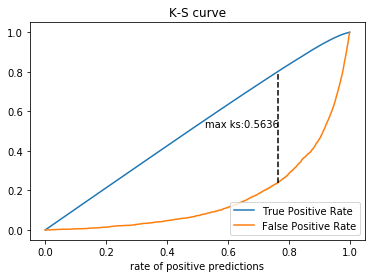

In [121]:
evaluate1=evaluate01(Y_test,testscore['Score'],index='ks',plot='ks')

- 绘制ROC曲线

The optimal cutoff(for ks) is 689.0
The maximum value of ks is: 0.5636
Score      689.000000
TP       33512.000000
FP         702.000000
FN        8344.000000
TN        2260.000000
rpp          0.763399
tpr          0.800650
fpr          0.237002
ppv          0.979482
acc          0.798161
f            0.881083
ks           0.563648
lift         1.048797
Name: 34213, dtype: float64


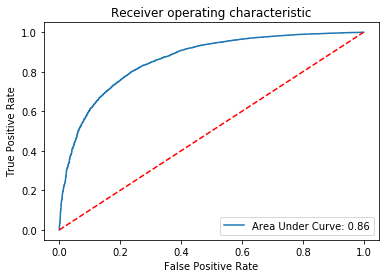

In [122]:
evaluate2=evaluate01(Y_test,testscore['Score'],index='ks',plot='roc')

## 新数据预测

- 读取待预测的新数据

In [123]:
test_data=pd.read_csv('data/CreditScore_data/give-me-some-credit-dataset/cs-test.csv',index_col=0)

In [124]:
test_data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0


- 对数据进行与训练数据相同的清洗,即使用之前定义的清洗函数

In [488]:
test_data.shape

(101503, 11)

In [125]:
test0=datacleaning(test_data)

In [490]:
test0.shape

(101503, 11)

- 由之前得到的分箱对象生成包含woe列的数据

In [126]:
test_woe=smgennew(test0,x_list)
test_woe.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30_59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60_89DaysPastDueNotWorse,NumberOfDependents,RevolvingUtilizationOfUnsecuredLines_woe,age_woe,NumberOfTime30_59DaysPastDueNotWorse_woe,DebtRatio_woe,MonthlyIncome_woe,NumberOfTimes90DaysLate_woe,NumberRealEstateLoansOrLines_woe,NumberOfTime60_89DaysPastDueNotWorse_woe,NumberOfDependents_woe
1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0,-1.2175,-0.3249,0.5408,0.1117,0.0025,0.389,-0.2413,0.2874,0.1489
2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0,0.1515,0.3025,0.5408,-0.2128,0.3397,0.389,-0.5904,0.2874,-0.2068
3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0,1.3365,0.3025,0.5408,-0.5947,-0.1884,0.389,0.2152,0.2874,-0.2068
4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0,0.7032,-0.3249,-0.9011,-0.5947,-0.4417,0.389,0.2152,0.2874,0.1489
5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0,-1.2175,-0.5507,0.5408,0.1117,-0.1884,0.389,-0.2413,0.2874,-0.1001


- 抽取WOE数据生成预测用数据
- 要加常数项列

In [128]:
T=test_woe.iloc[:,-len(x_list):]
T=sm.add_constant(T)

D:\tool\anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [498]:
T.head()

,const,RevolvingUtilizationOfUnsecuredLines_woe,age_woe,NumberOfTime30_59DaysPastDueNotWorse_woe,DebtRatio_woe,MonthlyIncome_woe,NumberOfOpenCreditLinesAndLoans_woe,NumberOfTimes90DaysLate_woe,NumberRealEstateLoansOrLines_woe,NumberOfTime60_89DaysPastDueNotWorse_woe,NumberOfDependents_woe
1,1.0,-1.2175,-0.3249,0.5408,0.1117,0.0025,0.1557,0.389,-0.2413,0.2874,0.1489
2,1.0,0.1515,0.3025,0.5408,-0.2128,0.3397,-0.0441,0.389,-0.5904,0.2874,-0.2068
3,1.0,1.3365,0.3025,0.5408,-0.5947,-0.1884,0.1557,0.389,0.2152,0.2874,-0.2068
4,1.0,0.7032,-0.3249,-0.9011,-0.5947,-0.4417,0.1557,0.389,0.2152,0.2874,0.1489
5,1.0,-1.2175,-0.5507,0.5408,0.1117,-0.1884,0.1557,0.389,-0.2413,0.2874,-0.1001


- 预测每一行数据是好客户的概率

In [129]:
y_pred=glmodel.predict(T)

In [130]:
y_pred.head()

1    0.909053
2    0.949668
3    0.976163
4    0.915432
5    0.891403
dtype: float64

- 预测每行数据的分数,生成总分数和每个特征的分数

In [131]:
Tscore=smscoregen(scorecard,T)

In [132]:
Tscore.head()

,const,RevolvingUtilizationOfUnsecuredLines_woe,age_woe,NumberOfTime30_59DaysPastDueNotWorse_woe,DebtRatio_woe,MonthlyIncome_woe,NumberOfTimes90DaysLate_woe,NumberRealEstateLoansOrLines_woe,NumberOfTime60_89DaysPastDueNotWorse_woe,NumberOfDependents_woe,RevolvingUtilizationOfUnsecuredLines_Score,age_Score,NumberOfTime30_59DaysPastDueNotWorse_Score,DebtRatio_Score,MonthlyIncome_Score,NumberOfTimes90DaysLate_Score,NumberRealEstateLoansOrLines_Score,NumberOfTime60_89DaysPastDueNotWorse_Score,NumberOfDependents_Score,Score
0,1.0,-1.2175,-0.3249,0.5408,0.1117,0.0025,0.389,-0.2413,0.2874,0.1489,31,68,93,81,76,89,68,83,79,668
1,1.0,0.1515,0.3025,0.5408,-0.2128,0.3397,0.389,-0.5904,0.2874,-0.2068,82,84,93,67,80,89,57,83,73,708
2,1.0,1.3365,0.3025,0.5408,-0.5947,-0.1884,0.389,0.2152,0.2874,-0.2068,126,84,93,50,74,89,84,83,73,756
3,1.0,0.7032,-0.3249,-0.9011,-0.5947,-0.4417,0.389,0.2152,0.2874,0.1489,102,68,48,50,71,89,84,83,79,674
4,1.0,-1.2175,-0.5507,0.5408,0.1117,-0.1884,0.389,-0.2413,0.2874,-0.1001,31,62,93,81,74,89,68,83,75,656


- 根据分数和训练得到的阈值判断客户的好坏,好客户是1,坏客户是0

In [133]:
test0[y]=(Tscore.Score>evaluate1.cutoff)*1
test0.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30_59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60_89DaysPastDueNotWorse,NumberOfDependents
1,1.0,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
2,1.0,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
3,0.0,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
4,0.0,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
5,1.0,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0


In [134]:
evaluate1.AUC

0.8609421718165055